# Test 5

### Import

In [74]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from backtesting import Backtest
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
from datetime import datetime
from lumibot.brokers import Alpaca
import matplotlib.pyplot as plt
from lumibot.backtesting import YahooDataBacktesting
import numpy as np
from dotenv import load_dotenv
load_dotenv()

True

In [60]:
file_path = "../Models/best_model.pt"

# Delete current model
if os.path.exists(file_path):
    os.remove(file_path)

### Device

In [61]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

device = "cpu"
print(f"Using device: {device}")

Using device: cpu


### Hyperparameter

In [62]:
# Model parameter
input_size = 20
output_size = 1
hidden_size = 10
num_layers = 4
dropout = 0.2

# Training parameter
batch_size = 1
num_epochs = 10
learning_rate = 0.0001
seq_size = 30

train_data_path = "../Data/train_dax_data.pkl"
test_data_path = "../Data/test_dax_data.pkl"

### LSTM Model

In [63]:
class Net(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, dropout=0.2):
        super(Net, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :]) 
        
        return x


### Dataloader

In [64]:
class FinanceDataset(Dataset):
    def __init__(self, input, output, seq_size):
        self.seq_size = seq_size
        
        self.inputs = input
        self.labels = output
        
    def __len__(self):
        return len(self.inputs) - self.seq_size

    def __getitem__(self, idx):
        x = self.inputs[idx:idx + self.seq_size]
        y = self.labels[idx + self.seq_size] 

        # Convert to tensors
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        return x, y

### Init

In [65]:
# Initialize model, loss function, optimizer
net = Net(input_size, output_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# Data

In [66]:
# Train
df = pd.read_pickle(train_data_path)

df = df[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]

display(df)

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

scaled_train_inputs = scaler.fit_transform(df.iloc[:, :-1].values)  
scaled_train_labels = scaler_y.fit_transform(df.iloc[:, -1].values.reshape(-1, 1))

^GDAXI_Open         float64
^GDAXI_High         float64
^GDAXI_Low          float64
^GDAXI_Close        float64
^GDAXI_Adj Close    float64
^GDAXI_Volume         int64
^GDAXI_month          int64
^GDAXI_weekday        int64
GC=F_Open           float64
GC=F_High           float64
GC=F_Low            float64
GC=F_Close          float64
GC=F_Adj Close      float64
GC=F_Volume           int64
BZ=F_Open           float64
BZ=F_High           float64
BZ=F_Low            float64
BZ=F_Close          float64
BZ=F_Adj Close      float64
BZ=F_Volume           int64
Y                    object
dtype: object


,^GDAXI_Open,^GDAXI_High,^GDAXI_Low,^GDAXI_Close,^GDAXI_Adj Close,^GDAXI_Volume,^GDAXI_month,^GDAXI_weekday,GC=F_Open,GC=F_High,...,GC=F_Close,GC=F_Adj Close,GC=F_Volume,BZ=F_Open,BZ=F_High,BZ=F_Low,BZ=F_Close,BZ=F_Adj Close,BZ=F_Volume,Y
0,9869.129883,9879.530273,9687.259766,9764.730469,9764.730469,67673900,1,4,1184.000000,1194.500000,...,1186.000000,1186.000000,138,57.630001,58.220001,55.520000,56.419998,56.419998,16707,9473.160156
1,9735.650391,9790.269531,9468.580078,9473.160156,9473.160156,105538300,1,0,1180.300049,1206.900024,...,1203.900024,1203.900024,470,56.290001,56.290001,52.669998,53.110001,53.110001,30065,9469.660156
2,9484.250000,9624.650391,9382.820312,9469.660156,9469.660156,96812300,1,1,1203.500000,1220.000000,...,1219.300049,1219.300049,97,53.230000,53.520000,50.529999,51.099998,51.099998,35494,9518.179688
3,9510.339844,9592.370117,9459.179688,9518.179688,9518.179688,82466600,1,2,1219.199951,1219.199951,...,1210.599976,1210.599976,29,51.060001,51.840000,49.680000,51.150002,51.150002,37082,9837.610352
4,9643.769531,9855.429688,9607.900391,9837.610352,9837.610352,114825000,1,3,1207.000000,1215.699951,...,1208.400024,1208.400024,92,51.000000,51.889999,49.820000,50.959999,50.959999,29469,9648.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,14113.009766,14160.870117,13890.540039,13914.070312,13914.070312,42893400,12,3,1818.099976,1818.099976,...,1787.000000,1787.000000,411,82.370003,83.860001,80.680000,80.980003,80.980003,16647,13940.929688
1970,13945.589844,14000.679688,13874.500000,13940.929688,13940.929688,28738700,12,4,1794.300049,1802.800049,...,1795.900024,1795.900024,49,81.730003,84.370003,81.339996,83.919998,83.919998,8621,13995.099609
1971,14047.419922,14063.139648,13966.349609,13995.099609,13995.099609,22975000,12,1,1803.400024,1826.300049,...,1814.800049,1814.800049,69,84.459999,85.669998,83.660004,84.330002,84.330002,7512,13925.599609
1972,14013.719727,14018.469727,13914.620117,13925.599609,13925.599609,27583800,12,2,1803.199951,1807.900024,...,1807.900024,1807.900024,434,84.599998,84.639999,81.949997,83.260002,83.260002,5384,14071.719727


In [67]:
# Test
test_df = pd.read_pickle(test_data_path)

test_df = test_df[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]


display(test_df)

scaled_test_inputs = scaler.transform(test_df.iloc[:,:-1].values) 
scaled_test_labels = scaler_y.transform(test_df.iloc[:, -1].values.reshape(-1, 1))

,^GDAXI_Open,^GDAXI_High,^GDAXI_Low,^GDAXI_Close,^GDAXI_Adj Close,^GDAXI_Volume,^GDAXI_month,^GDAXI_weekday,GC=F_Open,GC=F_High,...,GC=F_Close,GC=F_Adj Close,GC=F_Volume,BZ=F_Open,BZ=F_High,BZ=F_Low,BZ=F_Close,BZ=F_Adj Close,BZ=F_Volume,Y
0,11951.839844,12227.870117,11893.940430,12209.480469,12209.480469,63674200,10,0,1667.199951,1700.000000,...,1692.900024,1692.900024,410,86.510002,89.830002,86.510002,88.860001,88.860001,38251,12670.480469
1,12360.719727,12673.349609,12358.980469,12670.480469,12670.480469,80240300,10,1,1701.199951,1728.000000,...,1721.099976,1721.099976,291,88.889999,92.389999,88.690002,91.800003,91.800003,38971,12517.179688
2,12611.070312,12661.879883,12455.360352,12517.179688,12517.179688,62392400,10,2,1724.099976,1726.599976,...,1711.400024,1711.400024,418,91.650002,93.970001,90.900002,93.370003,93.370003,39563,12470.780273
3,12593.410156,12643.219727,12421.889648,12470.780273,12470.780273,53529600,10,3,1721.000000,1723.300049,...,1711.699951,1711.699951,133,93.830002,95.010002,92.730003,94.419998,94.419998,26200,12273.0
4,12414.780273,12497.519531,12272.589844,12273.000000,12273.000000,56973200,10,4,1710.099976,1710.099976,...,1700.500000,1700.500000,179,94.989998,98.589996,93.930000,97.919998,97.919998,36871,12272.94043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,16779.410156,16789.960938,16694.560547,16733.050781,16733.050781,63366400,12,2,2037.099976,2037.099976,...,2034.500000,2034.500000,258,79.250000,80.610001,79.080002,79.699997,79.699997,26913,16687.419922
305,16667.310547,16708.349609,16624.160156,16687.419922,16687.419922,57871300,12,3,2035.800049,2044.500000,...,2039.099976,2039.099976,228,79.139999,80.120003,77.849998,79.389999,79.389999,22237,16706.179688
306,16673.300781,16735.320312,16651.779297,16706.179688,16706.179688,46295300,12,4,2055.699951,2068.699951,...,2057.100098,2057.100098,202,79.440002,80.370003,78.830002,79.070000,79.070000,12334,16742.070312
307,16727.769531,16775.710938,16697.580078,16742.070312,16742.070312,37678900,12,2,2067.300049,2081.899902,...,2081.899902,2081.899902,586,80.739998,81.320000,79.489998,79.650002,79.650002,8282,16701.550781


In [68]:
# Initialize dataset and dataloader
dataset = FinanceDataset(scaled_train_inputs, scaled_train_labels, seq_size=seq_size)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

test_dataset = FinanceDataset(scaled_test_inputs, scaled_test_labels, seq_size=seq_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Training

/Users/danielstorch/Desktop/HTW/6 Semester/AKI-Trading-Model/.venv/lib/python3.11/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Bestes Modell gespeichert mit Test Loss: 0.0211
Epoch 1/10, Train Loss: 0.0000, Test Loss: 0.0211
Bestes Modell gespeichert mit Test Loss: 0.0093
Epoch 2/10, Train Loss: 0.0000, Test Loss: 0.0093
Bestes Modell gespeichert mit Test Loss: 0.0047
Epoch 3/10, Train Loss: 0.0000, Test Loss: 0.0047
Bestes Modell gespeichert mit Test Loss: 0.0026
Epoch 4/10, Train Loss: 0.0000, Test Loss: 0.0026
Epoch 5/10, Train Loss: 0.0000, Test Loss: 0.0026
Epoch 6/10, Train Loss: 0.0000, Test Loss: 0.0026
Epoch 7/10, Train Loss: 0.0000, Test Loss: 0.0027
Bestes Modell gespeichert mit Test Loss: 0.0026
Epoch 8/10, Train Loss: 0.0000, Test Loss: 0.0026
Bestes Modell gespeichert mit Test Loss: 0.0025
Epoch 9/10, Train Loss: 0.0000, Test Loss: 0.0025
Epoch 10/10, Train Loss: 0.0000, Test Loss: 0.0029


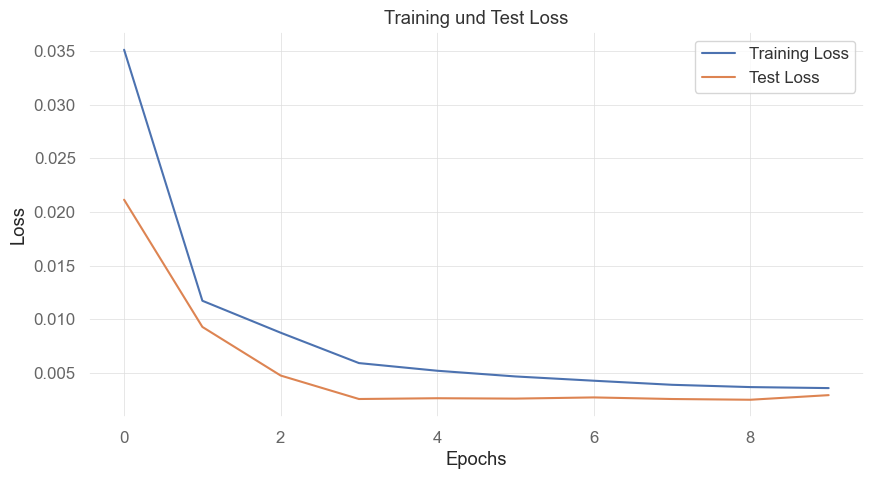

Training abgeschlossen. Bestes Modell gespeichert unter: ../Models/best_model.pt
Std Training Loss: 0.009153960666712903
Std Test Loss: 0.0056275122974789775
Min Training Loss: 0.0035764424392163083
Min Test Loss: 0.002489486860879143


In [69]:
os.makedirs("../Models", exist_ok=True)

# Modellpfad festlegen
best_model_path = "../Models/best_model.pt"

# Modell laden, falls es bereits existiert
if os.path.exists(best_model_path):
    net.load_state_dict(torch.load(best_model_path))
    print(f"Modell erfolgreich geladen von {best_model_path}")

# Parameter für Early Stopping und Modell-Speicherung
patience = 8
best_test_loss = float('inf')
early_stopping_counter = 0

losses = []
test_loss_vals = []

# Training loop mit Early Stopping
for epoch in range(num_epochs):
    net.train()
    epoch_loss = 0
    epoch_output = []
    # Training
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = net(inputs)
        epoch_output.append(outputs.detach().numpy())
        loss = criterion(outputs.squeeze(-1), labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    epoch_loss /= len(train_loader)
    avg_train_loss = epoch_loss / len(train_loader)
    losses.append(epoch_loss)

    # Modell auswerten auf dem Testset
    net.eval()
    running_test_loss = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            test_outputs = net(inputs)
            test_loss = criterion(test_outputs.squeeze(-1), labels)
            running_test_loss += test_loss.item()

        avg_test_loss = running_test_loss / len(test_loader)
        test_loss_vals.append(avg_test_loss)

        # Check for Early Stopping und Speichern des besten Modells
        if avg_test_loss < best_test_loss:
            best_epoch = epoch
            best_test_loss = avg_test_loss
            torch.save(net.state_dict(), best_model_path)
            print(f"Bestes Modell gespeichert mit Test Loss: {best_test_loss:.4f}")
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1

        # Ausgabe der Verluste
        print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

        # Early Stopping-Kriterium prüfen
        if early_stopping_counter >= patience:
            print(f"Early stopping nach {epoch + 1} Epochen. Test loss verbesserte sich nicht in den letzten {patience} Epochen.")
            break
    # print(f"Std Epoch Out: {np.std(epoch_output)}")
    # print(f"Mean Epoch Out: {np.mean(epoch_output)}")

# Plot der Trainings- und Testverluste
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.plot(test_loss_vals, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training und Test Loss')
plt.grid(True)
plt.show()

print(f"Training abgeschlossen. Bestes Modell gespeichert unter: {best_model_path}")
print(f"Std Training Loss: {np.std(losses)}")
print(f"Std Test Loss: {np.std(test_loss_vals)}")
print(f"Min Training Loss: {np.min(losses)}")
print(f"Min Test Loss: {np.min(test_loss_vals)}")

### Backtesting

In [70]:
scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

df = pd.read_pickle(train_data_path)
df = df[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]

display(df)

scaled_train_inputs = scaler.fit(df.iloc[:, :-1].values)  
scaled_train_labels = scaler_y.fit(df.iloc[:, -1].values.reshape(-1, 1))

model_path = "../Models/best_model.pt"

,^GDAXI_Open,^GDAXI_High,^GDAXI_Low,^GDAXI_Close,^GDAXI_Adj Close,^GDAXI_Volume,^GDAXI_month,^GDAXI_weekday,GC=F_Open,GC=F_High,...,GC=F_Close,GC=F_Adj Close,GC=F_Volume,BZ=F_Open,BZ=F_High,BZ=F_Low,BZ=F_Close,BZ=F_Adj Close,BZ=F_Volume,Y
0,9869.129883,9879.530273,9687.259766,9764.730469,9764.730469,67673900,1,4,1184.000000,1194.500000,...,1186.000000,1186.000000,138,57.630001,58.220001,55.520000,56.419998,56.419998,16707,9473.160156
1,9735.650391,9790.269531,9468.580078,9473.160156,9473.160156,105538300,1,0,1180.300049,1206.900024,...,1203.900024,1203.900024,470,56.290001,56.290001,52.669998,53.110001,53.110001,30065,9469.660156
2,9484.250000,9624.650391,9382.820312,9469.660156,9469.660156,96812300,1,1,1203.500000,1220.000000,...,1219.300049,1219.300049,97,53.230000,53.520000,50.529999,51.099998,51.099998,35494,9518.179688
3,9510.339844,9592.370117,9459.179688,9518.179688,9518.179688,82466600,1,2,1219.199951,1219.199951,...,1210.599976,1210.599976,29,51.060001,51.840000,49.680000,51.150002,51.150002,37082,9837.610352
4,9643.769531,9855.429688,9607.900391,9837.610352,9837.610352,114825000,1,3,1207.000000,1215.699951,...,1208.400024,1208.400024,92,51.000000,51.889999,49.820000,50.959999,50.959999,29469,9648.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1969,14113.009766,14160.870117,13890.540039,13914.070312,13914.070312,42893400,12,3,1818.099976,1818.099976,...,1787.000000,1787.000000,411,82.370003,83.860001,80.680000,80.980003,80.980003,16647,13940.929688
1970,13945.589844,14000.679688,13874.500000,13940.929688,13940.929688,28738700,12,4,1794.300049,1802.800049,...,1795.900024,1795.900024,49,81.730003,84.370003,81.339996,83.919998,83.919998,8621,13995.099609
1971,14047.419922,14063.139648,13966.349609,13995.099609,13995.099609,22975000,12,1,1803.400024,1826.300049,...,1814.800049,1814.800049,69,84.459999,85.669998,83.660004,84.330002,84.330002,7512,13925.599609
1972,14013.719727,14018.469727,13914.620117,13925.599609,13925.599609,27583800,12,2,1803.199951,1807.900024,...,1807.900024,1807.900024,434,84.599998,84.639999,81.949997,83.260002,83.260002,5384,14071.719727


In [71]:
import pandas as pd
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import numpy as np

model = Net(input_size, output_size, hidden_size, num_layers)

# Load state_dict only
model.load_state_dict(torch.load(model_path)) 
model.eval()

df = pd.read_pickle(test_data_path)
df = df[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]
display(df)
scaled_test_inputs = scaler.transform(df.iloc[:, :-1].values)  
scaled_test_labels = scaler_y.transform(df.iloc[:, -1].values.reshape(-1, 1))

test_data = FinanceDataset(scaled_test_inputs, scaled_test_labels, seq_size=seq_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

all_predictions = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        out = model(inputs) 
        
        all_predictions.append(out.numpy())  
        all_labels.append(labels.numpy())

all_predictions = np.concatenate(all_predictions)
all_labels = np.concatenate(all_labels)

print(f'Predicted values: {all_predictions.flatten()}')
print(f'Actual values: {all_labels.flatten()}')

output_df = pd.DataFrame({'Predicted': all_predictions.flatten(), 'Actual': all_labels.flatten()})
display(output_df)


/var/folders/fd/rkz1xz5d2fzgd9_trr31m_200000gn/T/ipykernel_78296/3780326204.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

,^GDAXI_Open,^GDAXI_High,^GDAXI_Low,^GDAXI_Close,^GDAXI_Adj Close,^GDAXI_Volume,^GDAXI_month,^GDAXI_weekday,GC=F_Open,GC=F_High,...,GC=F_Close,GC=F_Adj Close,GC=F_Volume,BZ=F_Open,BZ=F_High,BZ=F_Low,BZ=F_Close,BZ=F_Adj Close,BZ=F_Volume,Y
0,11951.839844,12227.870117,11893.940430,12209.480469,12209.480469,63674200,10,0,1667.199951,1700.000000,...,1692.900024,1692.900024,410,86.510002,89.830002,86.510002,88.860001,88.860001,38251,12670.480469
1,12360.719727,12673.349609,12358.980469,12670.480469,12670.480469,80240300,10,1,1701.199951,1728.000000,...,1721.099976,1721.099976,291,88.889999,92.389999,88.690002,91.800003,91.800003,38971,12517.179688
2,12611.070312,12661.879883,12455.360352,12517.179688,12517.179688,62392400,10,2,1724.099976,1726.599976,...,1711.400024,1711.400024,418,91.650002,93.970001,90.900002,93.370003,93.370003,39563,12470.780273
3,12593.410156,12643.219727,12421.889648,12470.780273,12470.780273,53529600,10,3,1721.000000,1723.300049,...,1711.699951,1711.699951,133,93.830002,95.010002,92.730003,94.419998,94.419998,26200,12273.0
4,12414.780273,12497.519531,12272.589844,12273.000000,12273.000000,56973200,10,4,1710.099976,1710.099976,...,1700.500000,1700.500000,179,94.989998,98.589996,93.930000,97.919998,97.919998,36871,12272.94043
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,16779.410156,16789.960938,16694.560547,16733.050781,16733.050781,63366400,12,2,2037.099976,2037.099976,...,2034.500000,2034.500000,258,79.250000,80.610001,79.080002,79.699997,79.699997,26913,16687.419922
305,16667.310547,16708.349609,16624.160156,16687.419922,16687.419922,57871300,12,3,2035.800049,2044.500000,...,2039.099976,2039.099976,228,79.139999,80.120003,77.849998,79.389999,79.389999,22237,16706.179688
306,16673.300781,16735.320312,16651.779297,16706.179688,16706.179688,46295300,12,4,2055.699951,2068.699951,...,2057.100098,2057.100098,202,79.440002,80.370003,78.830002,79.070000,79.070000,12334,16742.070312
307,16727.769531,16775.710938,16697.580078,16742.070312,16742.070312,37678900,12,2,2067.300049,2081.899902,...,2081.899902,2081.899902,586,80.739998,81.320000,79.489998,79.650002,79.650002,8282,16701.550781


Predicted values: [0.63919616 0.6468395  0.6566006  0.66797864 0.67967653 0.68988955
 0.7000712  0.7105301  0.7210183  0.73042226 0.7395434  0.74843836
 0.75659823 0.7636672  0.76895297 0.77421355 0.77957904 0.78461564
 0.78848076 0.79035175 0.7920958  0.79417944 0.7966832  0.7984183
 0.7973652  0.79537463 0.79303896 0.7908144  0.78820217 0.7844813
 0.7812712  0.7787268  0.77640796 0.7733635  0.76991355 0.76568854
 0.76036143 0.7537163  0.7485398  0.7459686  0.74627376 0.7491846
 0.75352335 0.7602495  0.7687255  0.7775806  0.785437   0.7939726
 0.8031466  0.81238556 0.82086563 0.82713246 0.8330926  0.838626
 0.8436878  0.848001   0.85094416 0.8542439  0.85803306 0.8621657
 0.86618364 0.8690181  0.8722609  0.8758148  0.8793769  0.88247895
 0.88418984 0.8855096  0.88634276 0.88666797 0.88545895 0.8846936
 0.884328   0.88431084 0.88421166 0.8834089  0.8835634  0.884652
 0.88641727 0.88826525 0.88909376 0.8897768  0.8902018  0.88965166
 0.88758063 0.8829036  0.87781715 0.8734009  0.8702935

,Predicted,Actual
0,0.639196,0.758208
1,0.646839,0.739756
2,0.656601,0.743888
3,0.667979,0.765022
4,0.679677,0.758389
...,...,...
274,0.978837,1.053087
275,0.979964,1.055482
276,0.980868,1.060066
277,0.981551,1.054891


In [72]:
pred = scaler_y.inverse_transform(all_predictions).reshape(-1, 1)
actual = scaler_y.inverse_transform(all_labels.reshape(-1, 1)).reshape(-1, 1)

# DataFrame erstellen
df_results = pd.DataFrame({
    "pred": pred.flatten(),
    "actual": actual.flatten(),
})

# DataFrame anzeigen
print(df_results)

             pred        actual
0    13446.641602  14378.509766
1    13506.489258  14234.030273
2    13582.918945  14266.379883
3    13672.008789  14431.860352
4    13763.604492  14379.929688
..            ...           ...
274  16106.045898  16687.419922
275  16114.869141  16706.179688
276  16121.942383  16742.070312
277  16127.296875  16701.550781
278  16132.977539  16751.640625

[279 rows x 2 columns]


In [81]:
os.makedirs("logs", exist_ok=True)
os.makedirs("results", exist_ok=True)

test_data = pd.read_pickle(test_data_path)
train_data = pd.read_pickle(train_data_path)

test_data = test_data[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]
train_data = train_data[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]

scaler = MinMaxScaler()
scaler.fit(train_data.iloc[:, :-1].values)

scaler_y = MinMaxScaler()
scaler_y.fit(train_data.iloc[:, -1].values.reshape(-1, 1))

model = Net(input_size, output_size, hidden_size, num_layers)
model_path = "../Models/best_model.pt"
model.load_state_dict(torch.load(model_path))
model.eval()

ALPACA_CREDS = {
    "API_KEY": os.getenv("ALPACA_API_KEY"),
    "API_SECRET": os.getenv("ALPACA_API_SECRET"),
    "PAPER": True,
}

# Strategy setup
start_date = datetime(2015, 1, 1)
end_date = datetime(2022, 12, 31)
broker = Alpaca(ALPACA_CREDS)

strategy = Backtest(
    name="Test4-Raw Material",
    broker=broker,
    parameters={
        "symbol": "^GDAXI",
        "cash_at_risk": 0.5,
        "model": model,
        "num_prior_days": 30,
        "dataset": test_data,
        "scaler": scaler,
        "scaler_y": scaler_y,
    },
)

# Run backtest
backtest_results = strategy.backtest(
    YahooDataBacktesting,
    start_date,
    end_date,
    name="Test4-Raw Material",
    parameters={
        "symbol": "^GDAXI",
        "cash_at_risk": 0.5,
        "model": model,
        "dataset": test_data,
        "num_prior_days": 30,
        "scaler": scaler,
        "scaler_y": scaler_y,
    },
    benchmark_asset="^GDAXI",
    show_plot=True,
    show_tearsheet=True,
)

# Save results
pd.DataFrame(backtest_results).to_csv("results/backtest_results.csv.gz", index=False, compression="gzip")

print("Backtesting complete. Results saved to backtest_results.csv.gz.")

/var/folders/fd/rkz1xz5d2fzgd9_trr31m_200000gn/T/ipykernel_78296/2748383669.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path)

TypeError: Backtest.__init__() got an unexpected keyword argument 'name'

/var/folders/6x/zpfvcglj30g1jqpb419n03_c0000gn/T/ipykernel_48786/3754966474.py:38: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



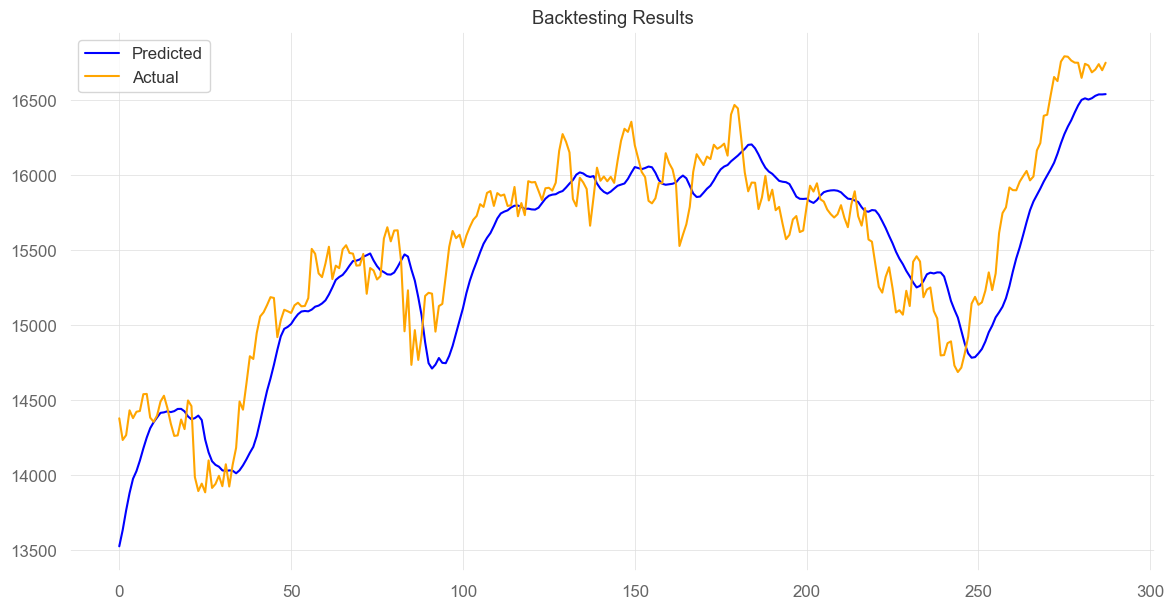

Mean Squared Error (MSE): 90123.47
Mean Absolute Error (MAE): 244.47


In [ ]:
# Backtesting-Funktion
def backtest_model(model, dataloader, scaler_y):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for X_batch, y_batch in dataloader:
            # Vorhersage
            output = model(X_batch)
            predictions.extend(output.numpy())
            actuals.extend(y_batch.numpy())

    # Rücktransformation der Vorhersagen und tatsächlichen Werte
    predictions = scaler_y.inverse_transform(np.array(predictions).reshape(-1, 1))
    actuals = scaler_y.inverse_transform(np.array(actuals).reshape(-1, 1))

    return predictions.flatten(), actuals.flatten()

# Backtesting starten
def run_backtest(test_df, model_path, seq_size):
    # Daten vorverarbeiten
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()
    train_data = pd.read_pickle(train_data_path)
    train_data = train_data[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]    
    scaler_X.fit(train_data.iloc[:, 1:-1].values)
    scaler_y.fit(train_data.iloc[:, -1].values.reshape(-1, 1))

    X_test = test_df.iloc[:, 1:-1]
    y_test = test_df.iloc[:, -1]

    X_test_scaled = scaler_X.transform(X_test.values)
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))

    # Sequenzen erstellen
    test_dataset = FinanceDataset(X_test_scaled, y_test_scaled, seq_size)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # Modell laden
    model = Net(input_size=input_size, output_size=output_size, hidden_size=hidden_size, num_layers=num_layers)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    # Backtesting durchführen
    predictions, actuals = backtest_model(model, test_dataloader, scaler_y)

    # Ergebnisse visualisieren
    plt.figure(figsize=(14, 7))
    plt.plot(predictions, label="Predicted", color="blue")
    plt.plot(actuals, label="Actual", color="orange")
    plt.title("Backtesting Results")
    plt.legend()
    plt.show()

    # Statistiken berechnen
    df_results = pd.DataFrame({"Actual": actuals, "Predicted": predictions})
    mse = ((df_results["Actual"] - df_results["Predicted"]) ** 2).mean()
    mae = np.abs(df_results["Actual"] - df_results["Predicted"]).mean()
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    return df_results

# Anwendung der Backtesting-Funktion
test_data = pd.read_pickle(test_data_path)  # Testdatensatz laden
test_data = test_data[['^GDAXI_Open', '^GDAXI_High', '^GDAXI_Low', '^GDAXI_Close',
                                '^GDAXI_Adj Close', '^GDAXI_Volume', '^GDAXI_month', '^GDAXI_weekday',
                                'GC=F_Open', 'GC=F_High', 'GC=F_Low', 'GC=F_Close',
                                'GC=F_Adj Close', 'GC=F_Volume',
                                'BZ=F_Open', 'BZ=F_High', 'BZ=F_Low', 'BZ=F_Close',
                                'BZ=F_Adj Close', 'BZ=F_Volume',
                                'Y']]
model_path = "../Models/best_model.pt"  # Pfad zum gespeicherten Modell

results = run_backtest(test_data, model_path, seq_size)